In [1]:
import sys
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import joblib
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
predict_product_info = pd.read_csv('train_info.csv')
predict_sales = pd.read_csv('train_sales.csv')

predict_product_info.drop(['material_name','category', 'bar_code'], axis = 1, inplace=True)

predict_product_info.drop_duplicates(inplace=True)
predict_sales.drop_duplicates(inplace=True)

# predict_product_info.fillna(-1, inplace=True)
# predict_sales.fillna(-1, inplace=True)

# 处理info的重复uuid的问题
ndf = pd.DataFrame(columns = predict_product_info.columns) #根据df的列名建一个空表ndf
uuids = set(predict_product_info['uuid'])
for u in uuids:
    one = predict_product_info.loc[predict_product_info['uuid'] == u] #获取所有uuid等于u的行，之后只会保存一行
    #在这里写if然后只保留一行，然后concat到ndf上，实现只保留一行
    olst = list(one['ingredient']) #或者用set
    zero = one.iloc[[0]] #iloc[行号]是series iloc[[行号]]是dataframe
    #zero['name']=str(olst)
    if len(olst) > 1: #等于1的就不用改了
        zero['ingredient'] = str(olst).replace('"[','').replace(']"','') #or =''.join(olst)
    ndf = pd.concat([ndf,zero]) #把选出来的zero加到ndf里

In [3]:
df_comb = predict_sales.merge(ndf, on='uuid')

In [4]:
print(df_comb.shape)
df_comb.head()

(150, 10)


,Unnamed: 0_x,uuid,channel,sales_period_,sales_value,Unnamed: 0_y,brand,material_name_zh,launch_date,ingredient
0,0,112777,EC,6,8.201381,28,POND'S,旁氏男士净效控油洁面乳 12X150G,2020-08-06,"['肉豆蔻酸', '甘油', '水', '丙二醇', '氢氧化钾', '棕榈酸', '乙二醇..."
1,1,112777,RT,6,5.497663,28,POND'S,旁氏男士净效控油洁面乳 12X150G,2020-08-06,"['肉豆蔻酸', '甘油', '水', '丙二醇', '氢氧化钾', '棕榈酸', '乙二醇..."
2,81,112777,EC,12,8.525868,28,POND'S,旁氏男士净效控油洁面乳 12X150G,2020-08-06,"['肉豆蔻酸', '甘油', '水', '丙二醇', '氢氧化钾', '棕榈酸', '乙二醇..."
3,82,112777,RT,12,5.531329,28,POND'S,旁氏男士净效控油洁面乳 12X150G,2020-08-06,"['肉豆蔻酸', '甘油', '水', '丙二醇', '氢氧化钾', '棕榈酸', '乙二醇..."
4,2,157886,EC,6,8.775864,14,DOVE,多芬滋养透亮护手霜 24X 40ML,2020-08-27,"['水', '甘油', '聚二甲基硅氧烷', '辛酸/癸酸甘油三酯', '棕榈酸', '乙二..."


In [5]:
df_comb.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis = 1, inplace=True)

In [6]:
final_id = df_comb[['uuid','channel','sales_period_']]
final_id

,uuid,channel,sales_period_
0,112777,EC,6
1,112777,RT,6
2,112777,EC,12
3,112777,RT,12
4,157886,EC,6
...,...,...,...
145,982584,RT,6
146,982584,EC,12
147,982584,RT,12
148,994949,RT,6


## 特征提取

In [7]:
#df_comb

In [8]:
## 成分
def ingredient(df_in):
    df = df_in.copy()
    s = set()
    for i in tqdm(df.ingredient):
        i = i.replace(" ",'').replace("',",' ').replace("'",'').replace("[",'').replace("]",'')
        i = set(i.split(' '))
        s = set.union(s, i)
    list_igd = list(s) # 共210种成分
    
    count_1 = -1
    for i in tqdm(df.ingredient):
        i = i.replace(" ",'').replace("',",' ').replace("'",'').replace("[",'').replace("]",'')
        i = i.split(' ')
        count_1 += 1
        df['ingredient'][count_1] = i
    
    for colname in tqdm(list_igd):
        count_2 = 0
        df['df_'+colname] = -1
        for sub in df['ingredient']:
            if colname in sub:
                df['df_'+colname][count_2] = 1
            else:
                df['df_'+colname][count_2] = 0
            count_2 += 1
    
    df_out = df.drop(['ingredient'],axis=1)
    
    return df_out

## 发行日期，按照日期远近的编码
#def launch_date(df_in):
    #df = df_in.copy()
    ## str to date
    #df['launch_date'] = pd.to_datetime(df['launch_date'])
    ## find base date
    #base_date = df['launch_date'].min() - datetime.timedelta(1)
    ## calculate the lenght of launch date
    #df['launch_date'] = df['launch_date'] - base_date
    ## date to int
    #df['launch_date'] = df['launch_date'].map(lambda x: x.days)
    
    #df_out = df.copy()
    
    #return df_out

## 发行日期，按照淡旺季编码
def launch_date(df_in):
    df = df_in.copy()
    df['launch_date']= pd.to_datetime(df['launch_date'])
    df['launch_date']= df['launch_date'].dt.month
    list_season = [3,5,7,8]
    
    count = 0
    for m in df['launch_date']:
        if m in list_season :
            df['launch_date'][count] = 1
        else:
            df['launch_date'][count] = 0
        count += 1
        
    df_out = df.copy()
    
    return df_out

## 品牌
def brand(df_in):
    df = df_in.copy()
    df = pd.concat([df, pd.get_dummies(df['brand'], prefix='brand')], axis=1)
    df_out = df.drop(['brand'],axis=1)
    
    return df_out

## 渠道
def channel(df_in):
    df = df_in.copy()
    df = pd.concat([df, pd.get_dummies(df['channel'], prefix='channel')], axis=1)
    df_out = df.drop(['channel'],axis=1)
    return df_out

## 有无促销
def promotion(df_in):
    df = df_in.copy()
    
    count = 0
    for p in range(len(df)):
        df['promotion'] = np.where(df['material_name_zh'].str.contains('.*?限量')|df['material_name_zh'].str.contains('.*?促销')|df['material_name_zh'].str.contains('.*?赠品'),1,0)
        count += 1

    df_out = df.copy()
    return df_out

## 是否为男士产品
def man(df_in):
    df = df_in.copy()
    
    count = 0
    for c in range(len(df)):
        df['man'] = np.where(df['material_name_zh'].str.contains('.*?男士'),1,0)
        count += 1

    df_out = df.copy()
    
    df_out = df.drop(['material_name_zh'],axis=1)
    
    return df_out

## 品类/功效
#def product(df_in):
    #df = df_in.copy()
    ##list_product = ['洁面','洗面','润肤','精华液','面膜','精华霜','身体乳','护手','洗发水','沐浴露','护发素','啫喱','颈膜','磨砂膏']
    
    #count = 0
    #for x in range(len(df)):
        #df['product']= np.where(df['material_name_zh'].str.contains('.*?洁面')|df['material_name_zh'].str.contains('.*?洗面'),1,
                                #df['material_name_zh'].str.contains('.*?润肤'),2,
                                #df['material_name_zh'].str.contains('.*?精华液'),3,
                                #df['material_name_zh'].str.contains('.*?面膜'),4,
                                #df['material_name_zh'].str.contains('.*?精华霜'),5,
                                #df['material_name_zh'].str.contains('.*?身体乳'),6,
                                #df['material_name_zh'].str.contains('.*?护手'),7,
                                #df['material_name_zh'].str.contains('.*?洗发水'),8,
                                #df['material_name_zh'].str.contains('.*?沐浴露'),9,
                                #df['material_name_zh'].str.contains('.*?护发素'),10,
                                #df['material_name_zh'].str.contains('.*?啫喱'),11,
                                #df['material_name_zh'].str.contains('.*?颈膜'),12,
                                #df['material_name_zh'].str.contains('.*?磨砂膏'),13,0)
        
        #count += 1
        
    #df_out = df.copy()
    
    #df_out = df.drop(['material_name_zh'],axis=1)
    
    #return df_out
    

In [9]:
df_proc = df_comb.copy()
print('Start processing...')
print('ingredient')
df_proc = ingredient(df_proc)
print('launch_date')
df_proc = launch_date(df_proc)
print('brand')
df_proc = brand(df_proc)
print('channel')
df_proc = channel(df_proc)
print('promotion')
df_proc = promotion(df_proc)
print('man')
df_proc = man(df_proc)
print('product')
#df_proc = product(df_proc)
print('processing finish!')

Start processing...
ingredient


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:23<00:00,  8.82it/s]


launch_date
brand
channel
promotion
man
product
processing finish!


In [10]:
df_proc

,uuid,sales_period_,sales_value,launch_date,df_琥珀酸二乙氧基乙酯,df_氯苯甘醚,df_CI77891,df_突厥蔷薇花提取物,df_月桂酸钠,df_四羟丙基乙二胺,...,df_二苯酮-4,df_细齿樱桃花提取物,brand_DOVE,brand_LUX,brand_POND'S,brand_VASELINE,channel_EC,channel_RT,promotion,man
0,112777,6,8.201381,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1,112777,6,5.497663,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,112777,12,8.525868,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,112777,12,5.531329,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,157886,6,8.775864,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,982584,6,9.505179,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
146,982584,12,9.870377,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
147,982584,12,9.844962,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
148,994949,6,9.887114,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0


0    0
1    0
2    0
3    0
Name: promotion, dtype: int32

## 标准化

In [12]:
df_nor = df_proc.copy()

Y = df_nor[['uuid','sales_value']]
X = df_nor.drop(['sales_value','uuid'],axis=1)

ss = StandardScaler()
std_data = ss.fit_transform(X)
origin_data = ss.inverse_transform(std_data)

df_std_ = pd.DataFrame(std_data)
df_std = pd.concat([Y, df_std_], axis=1)

df_std

,uuid,sales_value,0,1,2,3,4,5,6,7,...,210,211,212,213,214,215,216,217,218,219
0,112777,8.201381,-1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,1.920286,-0.750000,1.191367,-1.191367,-0.320844,4.213075
1,112777,5.497663,-1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,1.920286,-0.750000,-0.839372,0.839372,-0.320844,4.213075
2,112777,8.525868,1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,1.920286,-0.750000,1.191367,-1.191367,-0.320844,4.213075
3,112777,5.531329,1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,1.920286,-0.750000,-0.839372,0.839372,-0.320844,4.213075
4,157886,8.775864,-1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,1.259447,-0.204124,-0.520756,-0.750000,1.191367,-1.191367,-0.320844,-0.237356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,982584,9.505179,-1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,1.920286,-0.750000,-0.839372,0.839372,-0.320844,-0.237356
146,982584,9.870377,1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,1.920286,-0.750000,1.191367,-1.191367,-0.320844,-0.237356
147,982584,9.844962,1.0,0.5,-0.165521,-0.204124,-0.665062,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,1.920286,-0.750000,-0.839372,0.839372,-0.320844,-0.237356
148,994949,9.887114,-1.0,-2.0,-0.165521,-0.204124,1.503619,-0.237356,-0.165521,-0.165521,...,-0.436436,-0.320844,-0.793999,-0.204124,-0.520756,1.333333,-0.839372,0.839372,-0.320844,-0.237356


## PCA降维

In [13]:
Y = df_std[['uuid','sales_value']]
X = df_std.drop(['uuid','sales_value'],axis=1)

ew,ev = np.linalg.eig(np.cov(X.T))
ew_order = np.argsort(ew)[::-1]
ew_sort = ew[ew_order]
ev_sort = ev[:,ew_order]
print(ew_sort)
print(ev_sort)

[ 2.51278075e+01+0.00000000e+00j  2.21882577e+01+0.00000000e+00j
  1.91887280e+01+0.00000000e+00j  1.73573052e+01+0.00000000e+00j
  1.62472285e+01+0.00000000e+00j  1.44880368e+01+0.00000000e+00j
  1.39997096e+01+0.00000000e+00j  1.28847050e+01+0.00000000e+00j
  1.06821763e+01+0.00000000e+00j  9.77529873e+00+0.00000000e+00j
  8.68610061e+00+0.00000000e+00j  8.04114496e+00+0.00000000e+00j
  6.04165473e+00+0.00000000e+00j  5.72870329e+00+0.00000000e+00j
  5.17707766e+00+0.00000000e+00j  4.14322167e+00+0.00000000e+00j
  2.87596821e+00+0.00000000e+00j  2.48905502e+00+0.00000000e+00j
  2.36088833e+00+0.00000000e+00j  1.91449340e+00+0.00000000e+00j
  1.68429856e+00+0.00000000e+00j  1.39143283e+00+0.00000000e+00j
  1.27185969e+00+0.00000000e+00j  1.00671141e+00+0.00000000e+00j
  9.43719580e-01+0.00000000e+00j  7.78183109e-01+0.00000000e+00j
  6.69503695e-01+0.00000000e+00j  4.81096855e-01+0.00000000e+00j
  4.57165789e-01+0.00000000e+00j  4.01912161e-01+0.00000000e+00j
  3.68723619e-01+0.000000

<AxesSubplot:>

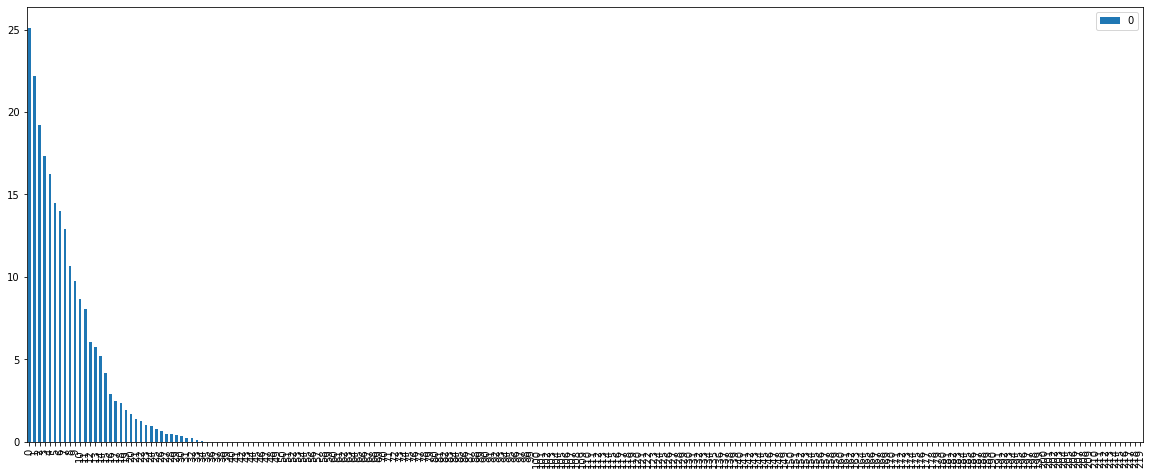

In [14]:
pd.DataFrame(ew_sort).plot(kind='bar',figsize=(20,8))

In [27]:
pca = PCA(n_components=0.9)
reduced_X = pca.fit_transform(X)

Xp90 = pd.DataFrame(reduced_X)
con90 = pd.concat([Y, Xp90], axis=1)
con90

,uuid,sales_value,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,112777,8.201381,-5.463816,4.582212,4.129162,-2.150395,5.004710,-6.082302,0.178848,2.483373,10.108920,4.764509,1.067892,0.240801,0.875479,9.265605,-1.126028,0.226161
1,112777,5.497663,-5.464591,4.514931,4.140461,-2.135483,5.104822,-6.100938,0.204537,2.414294,9.961249,4.817689,1.135653,0.180805,0.763105,9.224862,-1.226811,0.089575
2,112777,8.525868,-5.463816,4.582212,4.129162,-2.150395,5.004710,-6.082302,0.178848,2.483373,10.108920,4.764509,1.067892,0.240801,0.875479,9.265605,-1.126028,0.226161
3,112777,5.531329,-5.464591,4.514931,4.140461,-2.135483,5.104822,-6.100938,0.204537,2.414294,9.961249,4.817689,1.135653,0.180805,0.763105,9.224862,-1.226811,0.089575
4,157886,8.775864,1.936468,3.468438,-0.561784,-1.257701,-0.886917,2.187202,-2.259362,2.104310,0.953861,-0.813646,-3.109126,-1.725592,-3.456575,0.516500,1.975102,-0.368195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,982584,9.505179,-4.517695,3.301311,2.597417,-0.849870,3.406245,-4.308138,-0.160126,1.754996,3.995902,1.721263,0.627354,-0.056182,-0.746072,-7.018670,0.823525,-0.436527
146,982584,9.870377,-4.516920,3.368592,2.586117,-0.864782,3.306133,-4.289502,-0.185815,1.824074,4.143573,1.668083,0.559593,0.003815,-0.633698,-6.977926,0.924308,-0.299941
147,982584,9.844962,-4.517695,3.301311,2.597417,-0.849870,3.406245,-4.308138,-0.160126,1.754996,3.995902,1.721263,0.627354,-0.056182,-0.746072,-7.018670,0.823525,-0.436527
148,994949,9.887114,0.814950,-8.768116,-5.441404,1.953549,2.858317,-1.918879,0.632079,-0.919422,-0.602728,-0.498022,0.280160,0.044157,-0.737151,0.804534,-1.714743,-1.505984


In [28]:
!pip install plotly
import plotly.express as px

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)